In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [57]:
df_norm = pd.read_csv("all_predictions_with_confidences.csv")
df_64_50 = pd.read_csv("all_predictions_with_confidences_bs64_epochs50.csv")
df_64_hinge = pd.read_csv("all_predictions_with_confidences_bs64_hinge.csv")
df_64_hinge_50 = pd.read_csv("all_predictions_with_confidences_bs64_hinge_50epochs.csv")
df_64_lr001_10 = pd.read_csv("all_predictions_with_confidences_bs64_lr001_epochs10.csv")
df_64_lr001_50 = pd.read_csv("all_predictions_with_confidences_bs64_lr001_epochs50.csv")
df_64_wd02 = pd.read_csv("all_predictions_with_confidences_bs64_wd02.csv")
df_128 = pd.read_csv("all_predictions_with_confidences_bs128.csv")
df_128_50 = pd.read_csv("all_predictions_with_confidences_bs128_epochs50.csv")
df_128_hinge = pd.read_csv("all_predictions_with_confidences_bs128_hinge.csv")
df_128_hinge_50 = pd.read_csv("all_predictions_with_confidences_bs128_hinge_50epochs.csv")
new_amir = pd.read_csv("new_amir.csv")

In [3]:
def exit_layers(dataframe, threshold):
    
    exit_layer = [0]*13
    accordances = [0]*13
        
    # loop through all indexes in the dataframe
    for img_nr in dataframe['Image nr'].unique():
        
        img_data = dataframe[dataframe['Image nr'] == img_nr]
        last_layer_prediction = img_data[img_data['Prediction nr'] == 12]['Predictions'].values[0]
        
        # loop through all layers of that image
        for i in range(len(img_data)): 
            
            # store confidence in that layer
            conf = img_data.iloc[i]['Confidences']
            # store prediction in that layer
            pred = img_data.iloc[i]['Predictions']
            curr_layer = img_data.iloc[i]['Prediction nr']
            
            # Check if confidence is higher than the threshold            
            if conf >= threshold or curr_layer == 12: 
                
                exit_layer[int(curr_layer)] += 1
                
                # Check if the prediction matches the last layer's prediction
                accordances[int(curr_layer)] += int(last_layer_prediction == pred)
                break
                                     
    # Take mean
    for layer in range(1, 13):
        if exit_layer[int(layer)] != 0:
            accordances[int(layer)] = accordances[int(layer)] / exit_layer[int(layer)]
    
    exit_layer_count = np.array(exit_layer) 
    accordance_count = np.array(accordances)
    total_similarity_to_last_layer = sum(exit_layer_count[1:] * accordance_count[1:]) / (len(dataframe) / 12)
   
    layers = np.arange(1, 13, 1)
    average_layer_exit = sum(exit_layer_count[1:] * layers) / (len(dataframe) / 12)
    
    return exit_layer, accordances, total_similarity_to_last_layer, average_layer_exit

In [255]:
def visualize_vit_exits(dataframe, threshold):
    exit_layer, accordances, total_similarity_to_last_layer, average_layer_exit = exit_layers(dataframe, threshold)
    
    plt.figure(figsize=(8, 6))
    small_text = 10
    big_text = 15
    
    plt.bar(range(1, 13), exit_layer[1:])  # Starting from layer 1
    plt.xlabel('Prediction Layer at Exit', fontsize = big_text , weight='bold')
    plt.ylabel('Number of Images', fontsize = big_text, weight='bold')
    plt.xticks(fontsize=small_text, weight='bold')
    plt.yticks(fontsize=small_text, weight='bold')

    # Add text above the bars to show accordance
    for layer, count in enumerate(exit_layer[1:], start=1):
        plt.text(layer, count, f'{accordances[layer]:.2f}', ha='center', va='bottom', fontsize = "medium", weight='bold')
    
    print(f"Similarity = {total_similarity_to_last_layer:.2f}, Avg Exit Layer = {average_layer_exit:.2f}")
    plt.text(0.45, 0.93, f"Similarity = {total_similarity_to_last_layer:.2f}", transform=plt.gca().transAxes, fontsize=big_text, weight='bold')
    plt.text(0.45, 0.88, f"Avg Exit Layer = {average_layer_exit:.2f}", transform=plt.gca().transAxes, fontsize=big_text, weight='bold')
    plt.title(f'ViT Exit Layers (Threshold = {threshold})', fontsize=big_text, weight='bold')
    plt.savefig(f'for_poster9.png')
    plt.show()

Similarity = 1.00, Avg Exit Layer = 11.96


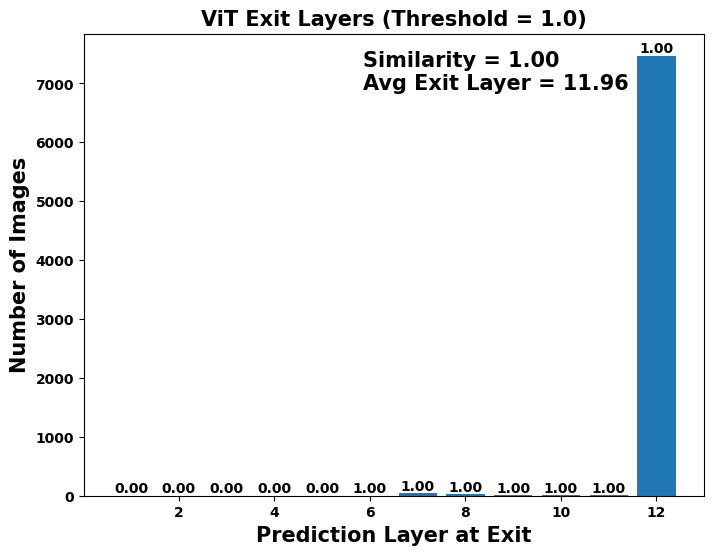

In [256]:
df = new_amir

visualize_vit_exits(df, 1.0)

In [271]:
def plot_results(dataframe, thresholds):
    plt.figure(figsize=(9, 6))
    small_text = 10
    big_text = 15
    min_vert = 10 # minimum vertical space
    colours = ["b", "g", "r", "c", "m"]
    
    descriptions = []

    for i, threshold in enumerate(thresholds):
        exit_layer, accordances, total_similarity_to_last_layer, average_layer_exit = exit_layers(dataframe, threshold)

        # vertical offset for accordances text
        offset = i * min_vert

        line, = plt.plot(range(1, 13), exit_layer[1:], label=f'Threshold = {threshold}', c = colours[i],linewidth=3.0)
        # Add text above the bars to show accordance
        for layer, count in enumerate(exit_layer[1:], start=1):
            if accordances[layer] > 0:
                plt.text(layer, count + 30 * (i+1), f'{accordances[layer]:.2f}', ha='center', va='bottom', c = colours[i], fontsize=small_text, weight='bold')
            
        descriptions.append(f"Threshold = {threshold:.3f}\tSimilarity = {total_similarity_to_last_layer:.2f}\tAvg Exit Layer = {average_layer_exit:.2f}")

    plt.ylim((0,2200))
    plt.title('Exit Layers and Accordances for Different Thresholds', fontsize=big_text, weight='bold')
    plt.xlabel('Layer', fontsize=big_text, weight='bold')
    plt.ylabel('Exit Layer Count', fontsize=big_text, weight='bold')
    plt.xticks(fontsize=small_text, weight='bold')
    plt.yticks(fontsize=small_text, weight='bold')
    legend_properties = {'weight':'bold'}
    plt.legend(loc='upper right', fontsize=big_text, prop=legend_properties)
    plt.savefig(f'multiple_thresholds.png')
    plt.show()
    for des in descriptions:
        print(des)
    
    

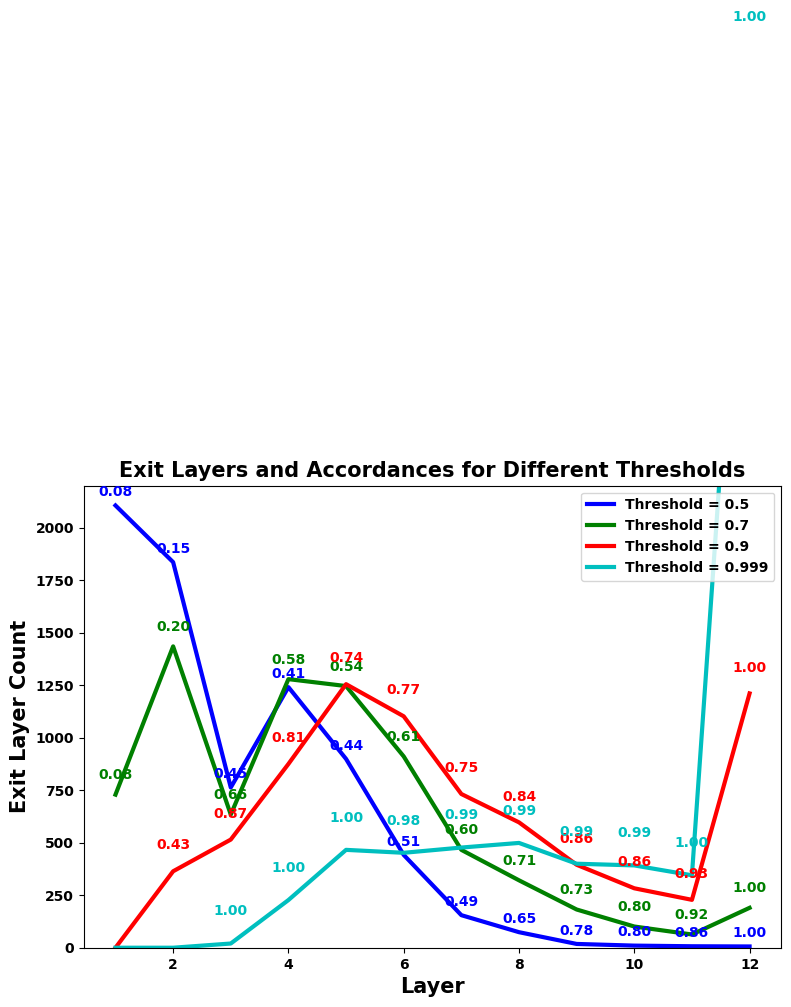

Threshold = 0.500	Similarity = 0.27	Avg Exit Layer = 2.95
Threshold = 0.700	Similarity = 0.49	Avg Exit Layer = 4.47
Threshold = 0.900	Similarity = 0.81	Avg Exit Layer = 6.88
Threshold = 0.999	Similarity = 1.00	Avg Exit Layer = 10.06


In [272]:
# Example usage
thresholds = [0.5, 0.7, 0.9, 0.999]
#thresholds = [0.5, 0.7]
plot_results(df, thresholds)

In [ ]:
# Example usage
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
plot_results(df, thresholds)

In [ ]:
# Example usage
thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
plot_results(df, thresholds)

In [86]:
np.random.randint(1, 7557)

2825

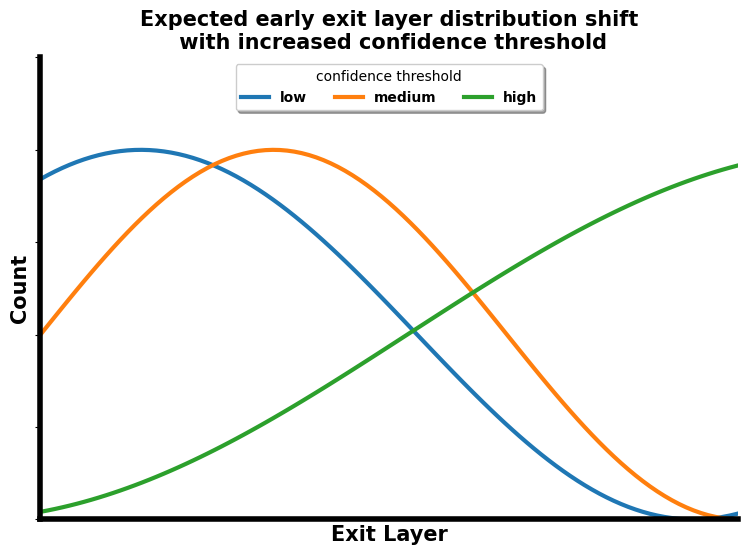

In [333]:
plt.figure(figsize=(9, 6)).set_linewidth(4)
plt.gca().spines['bottom'].set_linewidth(4)
plt.gca().spines['left'].set_linewidth(4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

x = np.linspace(0, 2*np.pi, 100)
plt.plot(x, np.sin(0.65*x+1)+1, label='low',linewidth=3.0)
plt.plot(x, np.sin(0.77*x)+1, label='medium',linewidth=3.0)
plt.plot(x, np.sin(0.4*x+5)+1, label='high',linewidth=3.0)

small_text = 10
big_text = 15

plt.title("Expected early exit layer distribution shift\n with increased confidence threshold", fontsize=big_text, weight='bold')
plt.xlabel('Exit Layer', fontsize=big_text, weight='bold')
plt.ylabel('Count', fontsize=big_text, weight='bold')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',bottom=False,top=False,labelleft=False)
plt.ylim(0, 2.5)
plt.xlim(0, 6.1)
legend_properties = {'weight':'bold'}
plt.legend(title = "confidence threshold",loc='upper center', fontsize=big_text, prop=legend_properties, bbox_to_anchor=(0.5, 1.0),
          ncol=3, fancybox=True, shadow=True)
plt.savefig(f'dist_shift.png')

In [281]:
np.arange(0, 3.14, 100)

array([0.])